# cool title plz

**Imports:**

In [1]:
# Import Libraries
import glob
import os
import pickle
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io
import scipy.ndimage
import seaborn as sn
from scipy.special import comb, factorial


from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.svm import SVC, SVR


from tensorflow.keras.layers import Conv1D, Dense, Dropout, GlobalAveragePooling1D, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

**Configuration:**

In [22]:
#Download data from: 'https://figshare.com/ndownloader/files/45297967?private_link=e2d70817514f8e40e400'

# ---  SET YOUR DATA PATH HERE !!!!! ---
base_path = "/Users/beno/Desktop/TU DELFT/ML for EE/Gesture Data/Training Data" 
test_path = "/Users/beno/Desktop/TU DELFT/ML for EE/Gesture Data/Test Data"

# ---  SET MOMENT ORDER (for Chebyshev method) ---
MAX_MOMENT_ORDER = 20  #According to the paper, 20 is the best-performing.


# ---  GESTURE MAPPING ---

# 'Wave'=1, 'Pinch'=2, 'Swipe'=3, 'Click'=4
gestures = {1: 'Wave', 2: 'Pinch', 3: 'Swipe', 4: 'Click'}

# Labels for the model (0, 1, 2, 3)
gesture_map_labels = {'Wave': 0, 'Pinch': 1, 'Swipe': 2, 'Click': 3}
num_classes = 4

# Check if the path exists:
if not os.path.isdir(base_path):
    print(f"Error: Directory not found at '{base_path}'")
else:
    print(f"Data directory set to: {base_path}")

Data directory set to: /Users/beno/Desktop/TU DELFT/ML for EE/Gesture Data/Training Data


**Chebyshev Math functions:**

In [3]:
def discrete_chebyshev_poly(l, x, L):
    """
    Computes the discrete Chebyshev polynomial t_l(x) of order l for
    a size L, evaluated at x.
    Based on Equation (2)[cite: 68].
    """
    s = 0
    fact_l = factorial(l, exact=True)
    for k in range(l + 1):
        term1 = (-1)**(l - k)
        term2 = comb(L - 1 - k, l - k, exact=True)
        term3 = comb(l + k, l, exact=True)
        term4 = comb(x, k, exact=True)
        s += term1 * term2 * term3 * term4
    return fact_l * s

def precompute_scaled_polys(max_order, L):
    """
    Precomputes the scaled discrete Chebyshev polynomials \tilde{t}_l(x).
    Based on Equations (5) and (6)[cite: 78, 82].
    Returns a matrix T[l, x] of shape (max_order + 1, L).
    """
    T = np.zeros((max_order + 1, L))
    for l in range(max_order + 1):
        beta_val = L**l
        if beta_val == 0:
            if l == 0:
                beta_val = 1.0 # \beta(0, L) = L^0 = 1
            else:
                continue 
        
        for x in range(L):
            T[l, x] = discrete_chebyshev_poly(l, x, L) / beta_val
    return T

def precompute_scaled_norm(max_order, L):
    """
    Precomputes the squared norm \tilde{\rho}(l, L) of the scaled polynomials.
    Based on Equations (3), (4), (5), (6)[cite: 71, 75, 76, 78, 82].
    Returns a vector R[l] of shape (max_order + 1,).
    """
    R = np.zeros(max_order + 1)
    for l in range(max_order + 1):
        if L-1 < l:
            continue
            
        try:
            rho_val = factorial(2 * l, exact=True) * comb(L + l, 2 * l + 1, exact=True)
        except ValueError:
            rho_val = 0 
        
        beta_val_sq = (L**l)**2
        
        if beta_val_sq == 0:
             if l == 0:
                beta_val_sq = 1.0
             else:
                continue
                
        R[l] = rho_val / beta_val_sq
    
    R[R == 0] = 1.0 # Avoid division by zero
    return R

**Feature Extraction Function:**

In [4]:
def extract_chebyshev_features(cvd_modulus_image, max_order, T_L_pre, T_H_pre, R_L_pre, R_H_pre):
    """
    Extracts the Chebyshev moments as a 1D feature vector.
    Implements Equation (10)  and (11)[cite: 150].
    
    T_{l,h} = (1 / (\tilde{\rho}(l,L)\tilde{\rho}(h,H))) * \sum_x \sum_y \tilde{t}_l(x) \tilde{t}_h(y) f(x,y)
    """
    
    L, H = cvd_modulus_image.shape
    
    if T_L_pre.shape[1] != L or T_H_pre.shape[1] != H:
        raise ValueError("Precomputed polynomial sizes do not match image dimensions")

    # Step 1: M = T_L @ f @ T_H.T  
    M = T_L_pre @ cvd_modulus_image @ T_H_pre.T
    
    # Step 2: Norms = R_L[:, None] @ R_H[None, :]
    Norms = R_L_pre[:, None] @ R_H_pre[None, :]
    Norms[Norms == 0] = 1.0 # Avoid division by zero
    
    # Step 3: Element-wise division for normalized moments T_{l,h}
    T_moments = M / Norms

    # Step 4: Flatten into feature vector F [cite: 150]
    # We only take moments where l + h <= max_order
    F = []
    for l in range(max_order + 1):
        for h in range(max_order + 1):
            if l + h <= max_order:
                F.append(T_moments[l, h])
                
    return np.array(F)

**Training Data Loading Function:**

In [5]:
def load_all_data(data_dir, gesture_map):
    """
    Loads all .mat files from the specified directory.
    This will find all 'Data_Training_Person_*.mat' files.
    """
    X_all = [] # List to hold all spectrograms
    y_all = [] # List to hold all labels (0, 1, 2, 3)
    
    # Find all training data files
    mat_files = glob.glob(os.path.join(data_dir, 'Data_Per_PersonData_Training_Person_*.mat'))
    
    if not mat_files:
        print(f"Warning: No .mat files found matching 'Data_Training_Person_*.mat' in {data_dir}")
        return [], []
        
    print(f"Found {len(mat_files)} person files...")
    
    for mat_file in mat_files:
        print(f"Loading data from {os.path.basename(mat_file)}...")
        data = scipy.io.loadmat(mat_file)
        
        # This is a (1, 4) numpy array
        doppler_signals = data['Data_Training']['Doppler_Signals'][0, 0]
        
        # --- BUGFIX ---
        # We must iterate over the *columns* (shape[1]), not the rows (len())
        num_gestures = doppler_signals.shape[1]  # This will be 4
        
        for gesture_idx in range(num_gestures): # This will loop 0, 1, 2, 3
            # Matlab index is 1-based
            gesture_name = gesture_map.get(gesture_idx + 1, 'Unknown')
            label = gesture_map_labels[gesture_name]
            
            # --- BUGFIX ---
            # Access the cell array for the gesture using the column index [0, gesture_idx]
            repeats = doppler_signals[0, gesture_idx]
            
            for repeat_idx in range(len(repeats)): # e.g., 466 for 'Wave'
                # This line was correct: [repeat_idx, 0] accesses the content
                # of the (N, 1) cell array.
                x = repeats[repeat_idx, 0]
                
                if not np.iscomplexobj(x):
                    print(f"Warning: Data for {gesture_name} repeat {repeat_idx} is not complex. Skipping.")
                    continue
                    
                X_all.append(x)
                y_all.append(label)
                
    print(f"Loaded {len(X_all)} total samples from {len(mat_files)} files.")
    return X_all, y_all

**Test Data Loading Function:**

In [6]:
def load_test_data(test_file_path):
    """
    Loads the test data from the 'Data_For_Test.mat' file.
    
    Assumes 'Data_rand' is a cell array where:
    - Column 1 has the data
    - Column 2 has the label (as a 1-based index)
    """
    X_test = []
    y_test = []
    
    if not os.path.exists(test_file_path):
        print(f"Error: Test file not found at '{test_file_path}'")
        return [], []
        
    print(f"Loading test data from {test_file_path}...")
    data = scipy.io.loadmat(test_file_path)
    data_rand = data['Data_rand']
    
    num_samples = data_rand.shape[0]
    
    for idx in range(num_samples):
        try:
            # --- MODIFIED LINE ---
            # Added [0][0] to access the data *inside* the nested cell
            # to match your sample code: test["Data_rand"][...][0][0][0]
            x = data_rand[idx, 0][0][0]
            
            # --- This line for the label is correct ---
            y_string = data_rand[idx, 1][0]
            
            # 2. Split the string by spaces and take the first word, e.g., 'Click'
            gesture_name = y_string.split(' ')[0]
            
            # 3. Map the name ('Click') to the label number (3)
            if gesture_name in gesture_map_labels:
                y = gesture_map_labels[gesture_name]
            else:
                print(f"Warning: Unknown gesture '{gesture_name}' in test sample {idx}. Skipping.")
                continue
            # --- END OF LABEL BLOCK ---
            
            if not np.iscomplexobj(x):
                print(f"Warning: Test sample {idx} is not complex. Skipping.")
                continue
                
            X_test.append(x)
            y_test.append(y)
            
        except Exception as e:
            print(f"Error processing test sample {idx}: {e}")
            
    print(f"Loaded {len(X_test)} total test samples.")
    return X_test, np.array(y_test)

**Feature extraction pipeline function**

In [7]:
def preprocess_and_extract_features(X_data, max_moment_order, target_size=None):
    """
    Applies the full feature extraction pipeline (CVD + Chebyshev).
    
    If 'target_size' is None, it's calculated from the first training sample.
    If 'target_size' is provided, all samples are resized to that size.
    
    Returns: (features, target_size)
    """
    
    if target_size is None:
        # --- Determine target size from first sample ---
        X_stft_mod = np.abs(X_data[0])
        X_cvd = np.fft.fft(X_stft_mod, axis=1) 
        X_cvd_mod = np.abs(X_cvd)
        TARGET_L, TARGET_H = X_cvd_mod.shape
        print(f"Target CVD image size set to: L={TARGET_L}, H={TARGET_H}")
    else:
        # --- Use provided target size ---
        TARGET_L, TARGET_H = target_size
        print(f"Using provided target size: L={TARGET_L}, H={TARGET_H}")
    
    print("Precomputing Chebyshev polynomials and norms...")
    T_L_pre = precompute_scaled_polys(max_moment_order, TARGET_L)
    T_H_pre = precompute_scaled_polys(max_moment_order, TARGET_H)
    R_L_pre = precompute_scaled_norm(max_moment_order, TARGET_L)
    R_H_pre = precompute_scaled_norm(max_moment_order, TARGET_H)
    print("Precomputation complete.")
    
    # --- Process all samples ---
    F_all = []
    
    for i, x in enumerate(X_data):
        X_stft_mod = np.abs(x)
        X_cvd = np.fft.fft(X_stft_mod, axis=1)
        X_cvd_mod = np.abs(X_cvd)
        
        # --- Check and resize if necessary ---
        L_current, H_current = X_cvd_mod.shape
        if L_current != TARGET_L or H_current != TARGET_H:
            zoom_L = TARGET_L / L_current
            zoom_H = TARGET_H / H_current
            # Use order=1 (bilinear) for interpolation, order=0 (nearest) is faster
            X_cvd_mod = scipy.ndimage.zoom(X_cvd_mod, (zoom_L, zoom_H), order=1)
        # --- End of resize block ---

        # 4. Extract Chebyshev features
        F = extract_chebyshev_features(X_cvd_mod, max_moment_order, 
                                       T_L_pre, T_H_pre, 
                                       R_L_pre, R_H_pre)
        F_all.append(F)
        
    return np.array(F_all), (TARGET_L, TARGET_H)

**Load Training Data:**

In [8]:
X_data, y_data = load_all_data(base_path, gestures)
y_data = np.array(y_data)

if len(X_data) == 0:
    print("Data loading failed. Please check your DATA_DIRECTORY path and file names.")
else:
    print(f"Successfully loaded {len(X_data)} samples.")

Found 6 person files...
Loading data from Data_Per_PersonData_Training_Person_B.mat...
Loading data from Data_Per_PersonData_Training_Person_C.mat...
Loading data from Data_Per_PersonData_Training_Person_A.mat...
Loading data from Data_Per_PersonData_Training_Person_D.mat...
Loading data from Data_Per_PersonData_Training_Person_E.mat...
Loading data from Data_Per_PersonData_Training_Person_F.mat...
Loaded 2433 total samples from 6 files.
Successfully loaded 2433 samples.


**Load Test Data:**

In [9]:
# Get the absolute path to the parent directory and join with the test file name
TEST_FILE_PATH = os.path.abspath(os.path.join(test_path, 'Data_For_Test_Random.mat'))
X_test_data, y_test_data = load_test_data(TEST_FILE_PATH)

if len(X_test_data) == 0:
    print("Test data loading failed. Please check your file path and structure.")

Loading test data from /Users/beno/Desktop/TU DELFT/ML for EE/Gesture Data/Test Data/Data_For_Test_Random.mat...
Loaded 643 total test samples.


**Extract Training Features:**

In [10]:
# Extract features and get the target_size from the training data
F_features_train, target_size = preprocess_and_extract_features(X_data, MAX_MOMENT_ORDER)
print(f"Training feature extraction complete. Feature vector shape: {F_features_train.shape}")

Target CVD image size set to: L=800, H=136
Precomputing Chebyshev polynomials and norms...
Precomputation complete.
Training feature extraction complete. Feature vector shape: (2433, 231)


**Extract Test Features:**

In [11]:
# Extract test features using the *same target_size*
print("Extracting test features...")
F_features_test, _ = preprocess_and_extract_features(X_test_data, 
                                                        MAX_MOMENT_ORDER, 
                                                        target_size=target_size)
print(f"Test feature extraction complete. Feature vector shape: {F_features_test.shape}")

Extracting test features...
Using provided target size: L=800, H=136
Precomputing Chebyshev polynomials and norms...
Precomputation complete.
Test feature extraction complete. Feature vector shape: (643, 231)


**Prepare data for classifier:**

In [12]:
# Assign the loaded training and test sets
X_train = F_features_train
y_train = y_data
X_test = F_features_test
y_test = y_test_data

# Normalize features (z-score)
# Fit the scaler ONLY on the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
# Transform the test data using the scaler fitted on training data
X_test_scaled = scaler.transform(X_test)

# One-hot encode labels for the CNN
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print(f"Training features shape: {X_train_scaled.shape}")
print(f"Test features shape:     {X_test_scaled.shape}")

Training features shape: (2433, 231)
Test features shape:     (643, 231)


**1D CNN Model Definition:**

In [13]:
def build_cnn_model(input_shape, num_classes):
    """
    Builds a 1D CNN model to classify the feature vectors.
    """
    model = Sequential()
    # Input shape is (num_features, 1)
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', 
                     input_shape=input_shape))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(0.4))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

**Build, Train, and Evaluate CNN**

In [14]:
# --- 1. Prepare for 1D CNN ---
# A 1D CNN expects input as (batch_size, steps, channels)
num_features = X_train_scaled.shape[1]
X_train_cnn = np.expand_dims(X_train_scaled, axis=-1)
X_test_cnn = np.expand_dims(X_test_scaled, axis=-1)

print(f"CNN input shape: {X_train_cnn.shape}")

# --- 2. Build and Train CNN Model ---
cnn_model = build_cnn_model(input_shape=(num_features, 1), num_classes=num_classes)
cnn_model.summary()

print("\nTraining CNN model...")
history = cnn_model.fit(
    X_train_cnn, y_train_cat,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_cnn, y_test_cat),
    verbose=1 # Set to 0 to hide epoch logs
)

# --- 3. Evaluate ---
print("\nEvaluating CNN model...")
loss, accuracy = cnn_model.evaluate(X_test_cnn, y_test_cat, verbose=0)
print(f"Test Accuracy (CNN): {accuracy * 100:.2f}%")

CNN input shape: (2433, 231, 1)


/Users/beno/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 229, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 227, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 113, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 113, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 111, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 109, 128)       │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,620 (404.77 KB)

 Trainable params: 103,620 (404.77 KB)

 Non-trainable params: 0 (0.00 B)


Training CNN model...
Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4201 - loss: 1.1547 - val_accuracy: 0.4914 - val_loss: 1.1223
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5384 - loss: 0.9639 - val_accuracy: 0.5832 - val_loss: 0.9296
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5717 - loss: 0.9224 - val_accuracy: 0.5599 - val_loss: 0.9989
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5935 - loss: 0.9054 - val_accuracy: 0.5941 - val_loss: 0.9400
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6050 - loss: 0.8771 - val_accuracy: 0.5972 - val_loss: 0.9563
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6104 - loss: 0.8640 - val_accuracy: 0.5692 - val_loss: 0.9410
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6231 - loss: 0.8557 - val_accuracy: 0.6065 - val_loss: 0.8779
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6321 - loss: 0.8328 - v


--- Training k-Nearest Neighbors (k-NN) Model ---
Test Accuracy (k-NN, k=7): 88.65%


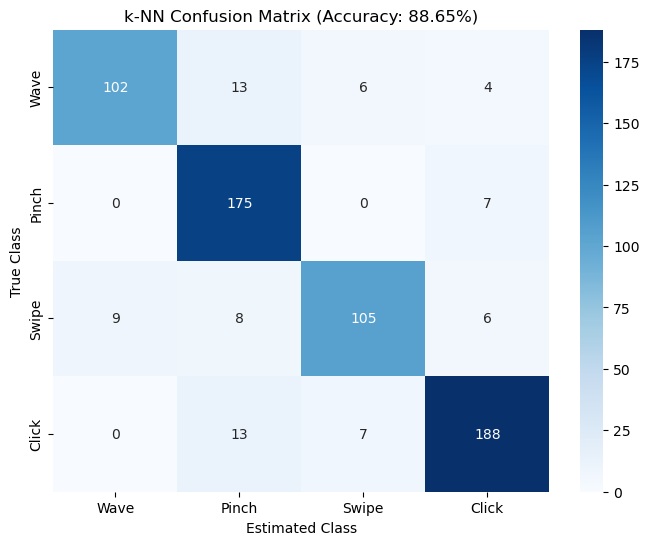

In [15]:
from sklearn.neighbors import KNeighborsClassifier

print("\n--- Training k-Nearest Neighbors (k-NN) Model ---")
# The paper used k=7 
knn_model = KNeighborsClassifier(n_neighbors=7)

# Train the model
knn_model.fit(X_train_scaled, y_train)

# --- Evaluate k-NN Model ---
y_pred_knn = knn_model.predict(X_test_scaled)
knn_accuracy = accuracy_score(y_test, y_pred_knn)
print(f"Test Accuracy (k-NN, k=7): {knn_accuracy * 100:.2f}%")

# --- Plot k-NN Confusion Matrix ---
cm_knn = confusion_matrix(y_test, y_pred_knn)
class_names = gesture_map_labels.keys()
plt.figure(figsize=(8, 6))
sn.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'k-NN Confusion Matrix (Accuracy: {knn_accuracy*100:.2f}%)')
plt.ylabel('True Class')
plt.xlabel('Estimated Class')
plt.show()

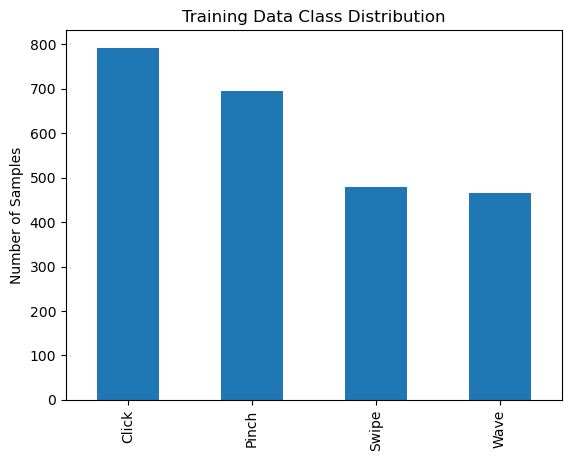

Training Data Distribution:
Click    32.552404
Pinch    28.606658
Swipe    19.687628
Wave     19.153309
Name: proportion, dtype: float64


In [16]:
import pandas as pd

# Check training data balance
# We use the 'gestures' map {1: 'Wave', ...} from cell 5
train_labels = [gestures[y+1] for y in y_train]
pd.Series(train_labels).value_counts().plot(kind='bar')
plt.title('Training Data Class Distribution')
plt.ylabel('Number of Samples')
plt.show()

print("Training Data Distribution:")
print(pd.Series(train_labels).value_counts(normalize=True) * 100)


--- Training (Recommended) Quadratic SVM Model ---
The paper found this was the best classifier (95.2% accuracy).
Test Accuracy (Quadratic SVM): 83.05%


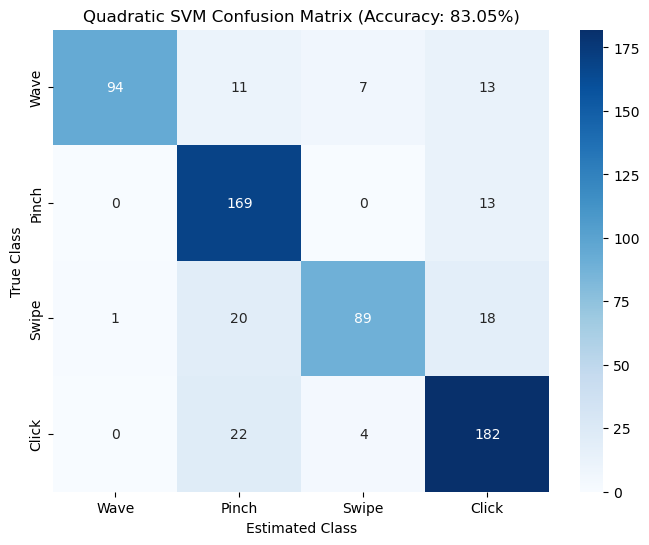

In [18]:
from sklearn.svm import SVC

print("\n--- Training (Recommended) Quadratic SVM Model ---")
print("The paper found this was the best classifier (95.2% accuracy).")

# 'poly' with degree=2 is a quadratic kernel[cite: 259, 260].
svm_model = SVC(kernel='poly', degree=2, C=1.0) 

# Train the model
svm_model.fit(X_train_scaled, y_train)

# --- Evaluate SVM Model ---
y_pred_svm = svm_model.predict(X_test_scaled)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"Test Accuracy (Quadratic SVM): {svm_accuracy * 100:.2f}%")

# --- Plot SVM Confusion Matrix ---
cm_svm = confusion_matrix(y_test, y_pred_svm)
class_names = gesture_map_labels.keys()
plt.figure(figsize=(8, 6))
sn.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Quadratic SVM Confusion Matrix (Accuracy: {svm_accuracy*100:.2f}%)')
plt.ylabel('True Class')
plt.xlabel('Estimated Class')
plt.show()